<a href="https://colab.research.google.com/github/Shtonks/CNNProj/blob/main/CS4287_Assign1_19231326_19274505.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Opening Notes

Rachel O' Donoghue (19274505) & Luke O' Loughlin (19231326) 

The code does execute to the end without error

Third party sources for our chosen model ResNet50V2 https://keras.io/api/applications/resnet/#resnet50v2-function

# Setup

In [ ]:
import os, random
import cv2
import numpy as np 
import keras
# from glob import glob
import tensorflow as tf

    model.compile(loss='mse', optimizer=Adam(lr=self.learingRate, l2=0.001))  # Add L2 regularization with strength 0.001

    model.add(layers.Dropout(0.5))  # Add dropout layer with rate 0.5

# Data 
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# Data Visualization
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Model
from keras import models, layers, optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, BatchNormalization,  GlobalAveragePooling2D
from keras.optimizers import SGD, Adam
from keras.applications import ResNet50V2 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Making sure colab gpu is active
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Listing path to files for convenience
train_path = "/content/drive/My Drive/CNNProj/MonkeyData/training/"
val_path = "/content/drive/My Drive/CNNProj/MonkeyData/validation/"
test_path = "/content/drive/My Drive/CNNProj/MonkeyData/test/"
labels_path = "/content/drive/My Drive/CNNProj/MonkeyData/monkey_labels.txt"

class_names = os.listdir(train_path)
class_names_test = os.listdir(val_path)

In [ ]:
# Read in txt file (since is comma seperated, use read_csv) and save into dataframe.
titles = ["Label", "Latin Name", "Common Name", "Training Images", "Valdation Images", "Test Images"]
class_labels_df = pd.read_csv(labels_path, names=titles, skiprows=1)

display(class_labels_df)

# Creating a new array just to store common names for ease of access
common_names = class_labels_df["Common Name"]

,Label,Latin Name,Common Name,Training Images,Valdation Images,Test Images
0,n0,alouatta_palliata\t,mantled_howler,116,21,20
1,n1,erythrocebus_patas\t,patas_monkey,124,23,20
2,n2,cacajao_calvus\t,bald_uakari,122,22,20
3,n3,macaca_fuscata\t,japanese_macaque,137,25,20
4,n4,cebuella_pygmea\t,pygmy_marmoset,116,21,20
5,n5,cebus_capucinus\t,white_headed_capuchin,126,23,20
6,n6,mico_argentatus\t,silvery_marmoset,117,21,20
7,n7,saimiri_sciureus\t,common_squirrel_monkey,127,23,20
8,n8,aotus_nigriceps\t,black_headed_night_monkey,118,22,20
9,n9,trachypithecus_johnii,nilgiri_langur,117,21,20


# Preparing Data for our Model

In [ ]:
# Hyperparameters, all can be adjusted as needed
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 50
PATIENCE = 4      # Patience for early stopping

# Immutable parameters
NUM_CLASSES = 10

In [ ]:
# Using ImageDataGenerator to preprocess our images
# All params are my selected preprocessing I want done to my images and will be randomly applied. Most are within ranges, so anything within that range
# Keeps our data unique everytime
train_datagen = ImageDataGenerator(
    rescale=1. / 255,           # The RGB vals in an image are [0, 255] by default. This scales down the vals to be [0, 1], normalising them
    rotation_range=40,          
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Keeping images natural for validation set
val_datagen = ImageDataGenerator(rescale=1. / 255)

# Training data generator
train_set = train_datagen.flow_from_directory(
    train_path,                                         
    target_size=(IMG_SIZE, IMG_SIZE),         # Will resize the images to fit this hyperparam size
    batch_size= BATCH_SIZE,                   # Setting batch size (hyperparam)
    class_mode='categorical')                 # Class mode chooses the label or arrays returned. Categorical is one-hot encoding, exactly needed for our data without natural order


val_set = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    shuffle = False)

test_set = val_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    shuffle = False)

Found 948 images belonging to 10 classes.
Found 222 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


# Data Visualisation


## Showing a random image of each monkey

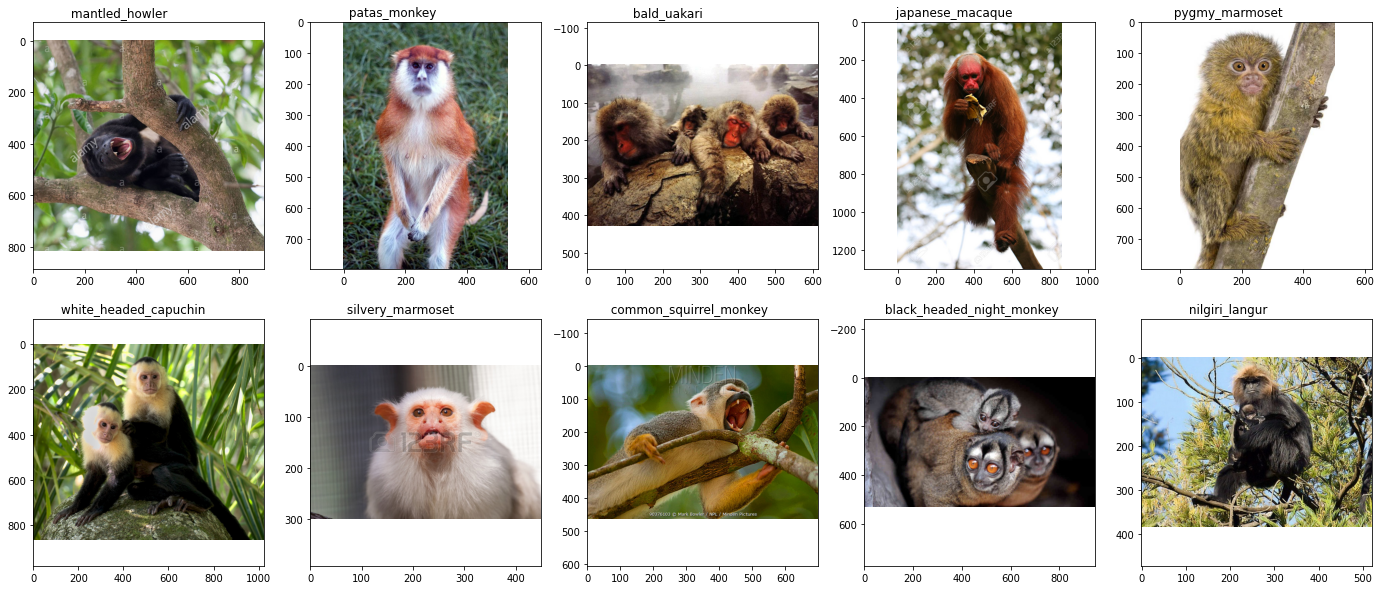

In [ ]:
  # Setting the size of the figures to display
  fig = plt.figure(figsize=(24, 10))

  # Iterating through all folders (n0, n1,...) containing species and choosing a random image to display from each
  i = 1
  for x in class_names:
    rand_img_file = random.choice(os.listdir(train_path + x))
    img = cv2.imread(train_path + x +'/'+ rand_img_file)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # Sets the colour for RGB, else it comes out with a blue tint
    
    plt.subplot(2,5,i)
    plt.axis("equal")
    plt.imshow(image)
    plt.title(common_names[i-1])
    i += 1
    if i>=11: break
  plt.show()

## Showing distrubution of monkey images per species

In [ ]:
# Creating a pie chart that represents the training data distribution
figPie = px.pie(
     names=common_names,
     values=class_labels_df["Training Images"],
     width=800,
     hole=0.4
)
figPie.update_layout({'title':{'text':'Train Class Distribution','x':0.45}})
figPie.show()

# Modelling

## ResNet50V2 and additional layer

In [ ]:
# Importing in Keras's ResNetV2 
pretrained_model= tf.keras.applications.ResNet50V2(
                      include_top=False,                      # Don't include the top layer of data. i.e. the input layer, as I want to set my own for that
                      input_shape=(IMG_SIZE, IMG_SIZE, 3),    # Setting the image shape, since top layer isn't included. Usinh hyperparams
                      pooling='avg',                          # Set to average pooling
                      weights='imagenet')                     # Using the model pretrained ImageNet dataset

# We freeze the pretrained layers of ResNet as they can identify moer general features, something which we dont need to waste time
# retraining every epoch. The final layers are most specific, which is what we want to have learn
pretrained_model.trainable = False

# Initially had dense layers here, but after reading into the final layer of ResNet50V2 (Global Max Pooling), there is no need for them or to flatten the data
headModel = pretrained_model.output
headModel = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(headModel)

my_resnet_model = tf.keras.Model(inputs=pretrained_model.input, outputs=headModel)

94668760/94668760 [==============================] - 4s 0us/step


In [ ]:
my_resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
my_resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

# Ensures we don't do too many or too few epochs
early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

# Running the actual model on training and validation data
history = my_resnet_model.fit(train_set, validation_data=val_set, epochs=EPOCHS, callbacks=early_stop)

Epoch 1/50
30/30 [==============================] - 428s 14s/step - loss: 1.3928 - acc: 0.5675 - val_loss: 0.4710 - val_acc: 0.9099
Epoch 2/50
30/30 [==============================] - 45s 2s/step - loss: 0.3937 - acc: 0.8956 - val_loss: 0.1973 - val_acc: 0.9685
Epoch 3/50
30/30 [==============================] - 42s 1s/step - loss: 0.2517 - acc: 0.9219 - val_loss: 0.1491 - val_acc: 0.9730
Epoch 4/50
30/30 [==============================] - 38s 1s/step - loss: 0.2005 - acc: 0.9346 - val_loss: 0.1299 - val_acc: 0.9640
Epoch 5/50
30/30 [==============================] - 46s 2s/step - loss: 0.1649 - acc: 0.9578 - val_loss: 0.1198 - val_acc: 0.9730
Epoch 6/50
30/30 [==============================] - 38s 1s/step - loss: 0.1603 - acc: 0.9599 - val_loss: 0.1071 - val_acc: 0.9640
Epoch 7/50
30/30 [==============================] - 37s 1s/step - loss: 0.1371 - acc: 0.9641 - val_loss: 0.0972 - val_acc: 0.9595
Epoch 8/50
30/30 [==============================] - 36s 1s/step - loss: 0.1118 - acc: 0.

# Results and Evaluation



## Plotting Results

In [ ]:
# Creating a function to graph the loss and accuracy of out training and validation data
def plot_loss_curves(history):
    
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["acc"]
    val_accuracy = history.history["val_acc"]
    
    epochs = range(len(history.history["loss"]))
    
    ## plotting loss:
    
    plt.plot(epochs,loss,label = "training loss")
    plt.plot(epochs,val_loss, label = "val loss")
    plt.title("loss_curve")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    
    ## plotting for accuracy:
    
    plt.figure()
    plt.plot(epochs,accuracy, label = "training accuracy")
    plt.plot(epochs,val_accuracy, label = "val accuracy")
    plt.title("Accuracy_curve")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()

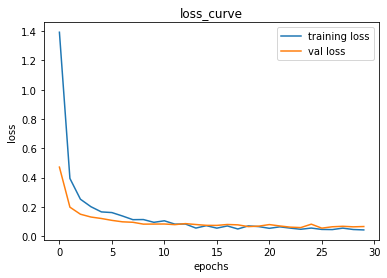

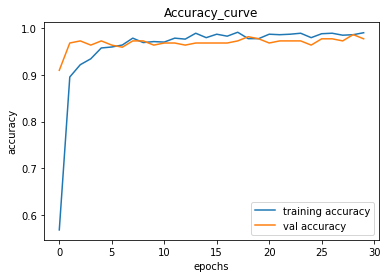

In [ ]:
plot_loss_curves(history=history)

## Retrieving metrics using test set

#### Classification Report

In [ ]:
test_true_ = test_set.classes   # Storing all true results for test set

test_pred_ = my_resnet_model.predict(test_set)       # Getting the prediction results for test set using our model
test_pred_ = np.argmax(test_pred_, axis = -1)        # Returns vals with highest value

print(classification_report(test_true_, test_pred_, target_names = common_names))

7/7 [==============================] - 66s 11s/step
                                 precision    recall  f1-score   support

 mantled_howler                       0.90      0.95      0.93        20
 patas_monkey                         1.00      1.00      1.00        20
 bald_uakari                          0.95      1.00      0.98        20
 japanese_macaque                     0.95      1.00      0.98        20
 pygmy_marmoset                       0.95      1.00      0.98        20
 white_headed_capuchin                1.00      0.95      0.97        20
 silvery_marmoset                     1.00      0.95      0.97        20
 common_squirrel_monkey               1.00      0.95      0.97        20
 black_headed_night_monkey            1.00      1.00      1.00        20
 nilgiri_langur                       1.00      0.95      0.97        20

                       accuracy                           0.97       200
                      macro avg       0.98      0.97      0.98       2

#### Confusion Matrix

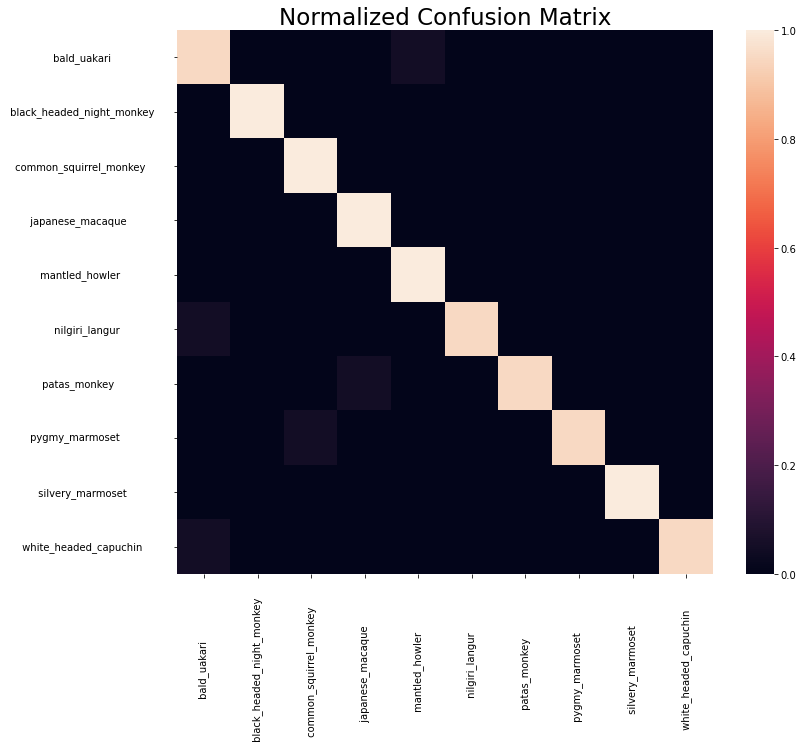

In [ ]:
test_true_ = list(test_set.classes)

# Confusion mat takes in the true values, predicted values and I have chosen to normalise my values
cf_matrix = confusion_matrix(test_true_, test_pred_, normalize='true')

# Plotting the matrix
plt.figure(figsize = (12,10))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(common_names)), yticklabels = sorted(set(common_names)))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()